### Select ROIs from raw image data folder

In [1]:
import cv2
import os

def select_single_roi(image, roi_index):
    print(f"Select ROI {roi_index} on the image. Press Enter to confirm.")
    roi = cv2.selectROI(f"Select ROI {roi_index}", image, showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()
    return roi

def create_output_dirs(base_dir, num_rois):
    output_dirs = []
    for i in range(num_rois):
        roi_dir = os.path.join(base_dir, f"ROI_{i+1}")
        os.makedirs(roi_dir, exist_ok=True)
        output_dirs.append(roi_dir)
    return output_dirs

def process_images(folder):
    input_folder = folder
    if not os.path.isdir(input_folder):
        print("Invalid folder path. Exiting.")
        return
    image_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith('.jpg')])
    if not image_files:
        print("No image files found in the folder. Exiting.")
        return
    first_image_path = os.path.join(input_folder, image_files[0])
    first_image = cv2.imread(first_image_path)
    if first_image is None:
        print(f"Could not read the first image: {first_image_path}. Exiting.")
        return

    rois = []
    print("Start selecting ROIs one by one. Press Enter when done with each selection. Press Esc when done selecting.")
    while True:
        roi_index = len(rois) + 1
        roi = select_single_roi(first_image, roi_index)
        if roi == (0, 0, 0, 0):  # If no ROI is selected
            break
        rois.append(roi)

    if len(rois) == 0:
        print("No ROIs selected. Exiting.")
        return

    print(f"{len(rois)} ROIs selected. Processing images...")

    output_dirs = create_output_dirs(input_folder, len(rois))

    for img_file in image_files:
        img_path = os.path.join(input_folder, img_file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image: {img_path}. Skipping.")
            continue

        for i, roi in enumerate(rois):
            x, y, w, h = roi
            cropped = image[y:y+h, x:x+w]
            save_path = os.path.join(output_dirs[i], img_file)
            cv2.imwrite(save_path, cropped)

    print(f"Processing complete. Cropped images are saved in subfolders inside {input_folder}.")



input_folder = "/Users/donglinhan/LargeFiles/oviposition/ET101"
if __name__ == "__main__":
    process_images(input_folder)

Start selecting ROIs one by one. Press Enter when done with each selection. Press Esc when done selecting.
Select ROI 1 on the image. Press Enter to confirm.
Select ROI 2 on the image. Press Enter to confirm.
Select ROI 3 on the image. Press Enter to confirm.
Select ROI 4 on the image. Press Enter to confirm.
Select ROI 5 on the image. Press Enter to confirm.
Select ROI 6 on the image. Press Enter to confirm.
Select ROI 7 on the image. Press Enter to confirm.
Select ROI 8 on the image. Press Enter to confirm.
Select ROI 9 on the image. Press Enter to confirm.
Select ROI 10 on the image. Press Enter to confirm.
Select ROI 11 on the image. Press Enter to confirm.
Select ROI 12 on the image. Press Enter to confirm.
Select ROI 13 on the image. Press Enter to confirm.
Select ROI 14 on the image. Press Enter to confirm.
Select ROI 15 on the image. Press Enter to confirm.
Select ROI 16 on the image. Press Enter to confirm.
Select ROI 17 on the image. Press Enter to confirm.
Select ROI 18 on t

In [2]:
import os
import pandas as pd
import shutil
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted
from scipy.signal import savgol_filter
from tqdm import tqdm
import pandas as pd

def load_images(image_folder):
    image_files = [img for img in os.listdir(image_folder) if img.endswith('.jpg')]
    sorted_files = natsorted(image_files)
    
    images = []
    for img in tqdm(sorted_files, desc="Loading Images"):
        images.append(cv2.imread(os.path.join(image_folder, img), cv2.IMREAD_GRAYSCALE))
    
    return np.array(images)

def identify_darkness_with_windows(image_stack):
    num_frames = image_stack.shape[0]
    height, width = image_stack.shape[1:]

    identified_pixels = []  # Store (x, y, B_start) for identified pixels

    for y in tqdm(range(height), desc="Processing Rows"):
        for x in range(width):
            intensity_profile = np.array(image_stack[:, y, x])
            if np.mean(intensity_profile[:60]) > np.mean(intensity_profile[-60:]) + 10:
                smoothed_profile = savgol_filter(intensity_profile, 15, 3)
                for start in range(num_frames - 270):  # Ensure space for both A and B windows
                    A = smoothed_profile[start:start+30]
                    B = smoothed_profile[start+30:start+270]
                    if np.sum(B < np.mean(A)) >= 240:
                        if np.median(B[:30]) - np.median(B[180:]) > 15:
                            if np.sum(smoothed_profile[start+270:] < np.median(B[120:240])) >= len(smoothed_profile[start+270:]) - 15:
                                if np.median(B[0:15]) - np.median(B[45:60]) > 5:
                                    if np.median (B[45:60]) - np.median(B[90:105]) > 2 and 5 > np.median(B[90:105]) - np.median(B[135:150]) > 2 and 5> np.median(B[135:150]) - np.median(B[180:195]) > 2 and 5> np.median(B[180:195]) - np.median(B[225:240]) > 2:
                                        identified_pixels.append((x, y, start+30))
                                        break

    return identified_pixels
    
def filter_identified_pixels(identified_pixels, max_frame=2880):
    return [pixel for pixel in identified_pixels if pixel[2] <= max_frame]

def plot_identified_pixels_on_roi(image_stack, identified_pixels, folder_path):
    # Take the first frame of the image stack to plot the identified pixels on it
    first_frame = image_stack[0]
    
    # Create a figure and plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(first_frame, cmap='gray')
    
    # Overlay the identified pixels on the first frame (ROI coordinates)
    for (x, y, _) in identified_pixels:
        plt.scatter(x, y, color='red', s=10, label="Identified Pixel" if x == identified_pixels[0][0] else "")

    plt.title("Identified Pixels on ROI")
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.legend([], [], frameon=False)
    
    # Save the figure as a PNG image
    output_filename = os.path.join(folder_path, "identified_pixels.png")
    plt.savefig(output_filename, format='png')
    
    # Close the plot to free up memory
    plt.close()


def analyze_roi_folder(folder_path):
    
    image_folder = folder_path
    image_stack = load_images(image_folder)
    identified_pixels = identify_darkness_with_windows(image_stack)
    identified_pixels = filter_identified_pixels(identified_pixels, max_frame=2880)
    plot_identified_pixels_on_roi(image_stack, identified_pixels, folder_path)
    roi_onset_counts = {}
    onset_frames = [pixel[2] for pixel in identified_pixels]
    roi_onset_counts, _ = np.histogram(onset_frames, bins=range(0, image_stack.shape[0] + 60, 60))

    return roi_onset_counts

def process_roi_folders(base_folder):

    image_output_folder = os.path.join(base_folder, "image_output")
    os.makedirs(image_output_folder, exist_ok=True)
    results = pd.DataFrame()

    for roi_folder in natsorted([f for f in os.listdir(base_folder) if f.startswith("ROI_") and os.path.isdir(os.path.join(base_folder, f))]):
        roi_path = os.path.join(base_folder, roi_folder)
        roi_id = roi_folder.split("_")[1]

        print(f"Analyzing folder: {roi_path}")
        roi_onset_counts = analyze_roi_folder(roi_path)
        results[roi_id] = pd.Series(roi_onset_counts)
    
    excel_output_path = os.path.join(base_folder, "roi_analysis_results.xlsx")
    results.to_excel(excel_output_path, index=False)

    print(f"Processing complete. Images saved to '{image_output_folder}' and results saved to '{excel_output_path}'.")

if __name__ == "__main__":
    # Hardcoded folder path
    input_folder = "/Users/donglinhan/LargeFiles/oviposition/ET101"
    process_roi_folders(input_folder)

Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_1


Processing Rows: 100%|████████████████████████| 24/24 [00:00<00:00, 5272.54it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_2


Processing Rows: 100%|████████████████████████| 41/41 [00:00<00:00, 3406.15it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_3


Processing Rows: 100%|████████████████████████| 34/34 [00:00<00:00, 4418.48it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_4


Processing Rows: 100%|████████████████████████| 33/33 [00:00<00:00, 4146.80it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_5


Processing Rows: 100%|████████████████████████| 40/40 [00:00<00:00, 2881.25it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_6


Processing Rows: 100%|████████████████████████| 31/31 [00:00<00:00, 3586.66it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_7


Processing Rows: 100%|████████████████████████| 462/462 [00:24<00:00, 18.77it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_8


Processing Rows: 100%|████████████████████████| 28/28 [00:00<00:00, 4687.68it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_9


Processing Rows: 100%|████████████████████████| 32/32 [00:00<00:00, 4776.09it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_10


Processing Rows: 100%|████████████████████████| 464/464 [01:46<00:00,  4.35it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_11


Processing Rows: 100%|████████████████████████| 36/36 [00:00<00:00, 2476.59it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_12


Processing Rows: 100%|██████████████████████████| 25/25 [00:01<00:00, 15.55it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_13


Processing Rows: 100%|████████████████████████| 440/440 [01:59<00:00,  3.67it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_14


Processing Rows: 100%|████████████████████████| 438/438 [00:52<00:00,  8.27it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_15


Processing Rows: 100%|████████████████████████| 423/423 [01:20<00:00,  5.25it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_16


Processing Rows: 100%|████████████████████████| 28/28 [00:00<00:00, 3325.51it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_17


Processing Rows: 100%|████████████████████████| 453/453 [01:38<00:00,  4.59it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_18


Processing Rows: 100%|████████████████████████| 35/35 [00:00<00:00, 4457.42it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_19


Processing Rows: 100%|████████████████████████| 453/453 [02:14<00:00,  3.38it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_20


Processing Rows: 100%|████████████████████████| 444/444 [01:11<00:00,  6.25it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_21


Processing Rows: 100%|████████████████████████| 461/461 [01:28<00:00,  5.23it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_22


Processing Rows: 100%|████████████████████████| 460/460 [02:31<00:00,  3.03it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_23


Processing Rows: 100%|████████████████████████| 474/474 [02:56<00:00,  2.68it/s]


Analyzing folder: /Users/donglinhan/LargeFiles/oviposition/ET101/ROI_24


Processing Rows: 100%|████████████████████████| 442/442 [01:56<00:00,  3.79it/s]


Processing complete. Images saved to '/Users/donglinhan/LargeFiles/oviposition/ET101/image_output' and results saved to '/Users/donglinhan/LargeFiles/oviposition/ET101/roi_analysis_results.xlsx'.


In [4]:
import pandas as pd

# Step 1: Read the Excel sheet into a DataFrame
file_path = '/Users/donglinhan/Desktop/EHyper2025/ET/ET_LVP_LONG.xlsx'  # Replace with your file path
#sheet_name = 'Sheet1'  # Replace with your sheet name, if necessary
df = pd.read_excel(file_path)

# Step 2: Convert all non-zero values to 1 (binary conversion)
binary_df = df.applymap(lambda x: 1 if x > 4 else 0)

# Step 3: Calculate the median index of non-zero values for each column
def median_nonzero_index(col):
    nonzero_indices = col[col == 1].index
    if len(nonzero_indices) > 0:
        return nonzero_indices.to_series().median()
    else:
        return float('inf')  # Handle columns with no non-zero values

median_indices = binary_df.apply(median_nonzero_index, axis=0)

# Step 4: Sort the columns based on the median index of non-zero values
sorted_columns = median_indices.sort_values().index
sorted_df = binary_df[sorted_columns]

# Save or print the result
print(sorted_df)

# Optionally, save the sorted DataFrame to a new Excel file
sorted_df.to_excel('/Users/donglinhan/Desktop/EHyper2025/ET/sorted_ET_LVP_LONG.xlsx', index=False)

    ET015-15  ET015-18  ET015-24  ET011-20  ET015-10  ET015-6  ET015-17  \
0          0         0         0         0         0        0         0   
1          0         0         0         0         0        0         0   
2          0         0         0         0         0        0         0   
3          0         0         0         0         0        0         0   
4          0         0         0         0         0        0         0   
..       ...       ...       ...       ...       ...      ...       ...   
67         0         0         0         0         0        0         0   
68         0         0         0         0         0        0         0   
69         0         0         0         0         0        0         0   
70         0         0         0         0         0        0         0   
71         0         0         0         0         0        0         0   

    ET015-14  ET011-18  ET015-4  ...  ET011-4  ET011-9  ET015-1  ET011-2  \
0          0         0 

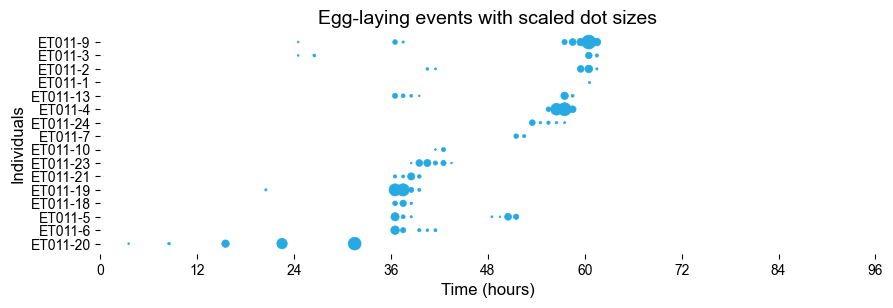

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file (replace with your actual file path)
# file_path = '/Users/donglinhan/Desktop/EHyper2025/ET/REP/sorted_ET_LVP_LONG.xlsx'
file_path = '/Users/donglinhan/Desktop/EHyper2025/ET/REP/ET_LEGENDS.xlsx'
df = pd.read_excel(file_path, index_col=0)

# Define time span
time_span = (0, 96)  # Time span from 0 to 48 hours

# Set up the plot
fig, ax = plt.subplots(figsize=(10, len(df.columns) * 0.18))  # Adjust height based on number of individuals
plt.rcParams["font.family"] = "Arial"  # Set global font

# Normalize marker sizes for clarity
max_value = df.max().max()  # Get the maximum value in the dataset
min_size, max_size = 1, 100  # Define min and max marker sizes

# Loop through each column and plot numerical values as dots with sizes
for idx, column in enumerate(df.columns):
    event_times = df.index[df[column] > 0]  # Get indices where values are > 0
    event_values = df[column][df[column] > 0]  # Extract corresponding values
    
    # Scale dot sizes based on numerical values
    sizes = ((event_values / max_value) * (max_size - min_size)) + min_size  
    
    # Plot events with scaled dot sizes
    ax.scatter(event_times, [idx] * len(event_times), marker='o', color='#27aae1', s=sizes, linewidths=0.5)


# Set labels and limits
ax.set_xlim(time_span)
ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df.columns)  # Label individuals
ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Individuals', fontsize=12)
ax.set_title('Egg-laying events with scaled dot sizes', fontsize=14)

# Adjust x-axis ticks
xticks = [x for x in range(0, 97, 12)]  
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])

# Remove frame (spines)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Save the plot
# plt.savefig('/Users/donglinhan/Desktop/EHyper2025/ET/REP/LVP_LONG_scaled.svg', format='svg', bbox_inches='tight')
plt.savefig('/Users/donglinhan/Desktop/EHyper2025/ET/REP/legends.svg', format='svg', bbox_inches='tight')
# plt.savefig('/Users/donglinhan/Desktop/EHyper2025/ET/REP/LVP_LONG_scaled.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [1]:
import pandas as pd
import numpy as np

# Load both sheets
activity_file_path = '/Users/donglinhan/Desktop/EHyper2025/ET/REP/REP_ACT_LVP_LONG.xlsx'
activity_df = pd.read_excel(activity_file_path, index_col=0)
egglay_file_path = '/Users/donglinhan/Desktop/EHyper2025/ET/REP/REP_ET_LVP_LONG.xlsx'
egg_laying_df = pd.read_excel(egglay_file_path, index_col=0)

# Function to compute weighted median egg-laying time
def weighted_median(series):
    times = np.arange(len(series))  # Time points (0 to 47 hours)
    values = series.values  # Egg counts at each time point
    
    # Compute cumulative weight
    cumulative_weights = np.cumsum(values)
    total_weight = cumulative_weights[-1] if cumulative_weights[-1] > 0 else 1  # Avoid division by zero
    
    # Find the weighted median time
    weighted_median_time = times[np.searchsorted(cumulative_weights, total_weight / 2)]
    return weighted_median_time

# Compute weighted median time for each column
median_times = egg_laying_df.apply(weighted_median, axis=0)
sorted_columns = median_times.sort_values().index

# Apply sorting to both sheets
egg_laying_sorted = egg_laying_df[sorted_columns]
activity_sorted = activity_df[sorted_columns]  # Apply the same column order

# Save sorted sheets back to Excel
egg_laying_output_path = "/Users/donglinhan/Desktop/EHyper2025/ET/REP/sorted_ET_LVP_LONG.xlsx"
activity_output_path = "/Users/donglinhan/Desktop/EHyper2025/ET/REP/sorted_ACT_LVP_LONG.xlsx"
egg_laying_sorted.to_excel(egg_laying_output_path)
activity_sorted.to_excel(activity_output_path)
